# Denoising autoencoder

Modified from https://github.com/eugeniaring/Pytorch-tutorial/blob/main/denAE.ipynb

In [1]:
# Imports
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
from random import sample
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST

## Download MNIST and show some samples

In [2]:
# Download training and testset of MNIST
train_dataset = MNIST('../../data', train=True, download=True, transform=transforms.ToTensor())
val_dataset = MNIST('../../data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512)

## Define the autoencoder

In [4]:
# Autoencoder class
class AutoEncoder(nn.Module):

    def __init__(self, img_size, code_size):
        super().__init__()
        self.img_size = img_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(3*3*32, code_size)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(code_size, 3*3*32),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    # Forward pass
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.reshape(-1, 1, self.img_size, self.img_size)

## Initialize model, loss and optimizer

In [5]:
# Set params
img_size = 28
code_size = 8

# Create model
model = AutoEncoder(img_size, code_size)

# Set training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set model to device
model.to(device)

# Define loss function
loss_fn = torch.nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model

In [6]:
# Function to add noise to images
def add_noise(inputs, noise_factor=0.3):
    noise = inputs + noise_factor * torch.randn_like(inputs)
    noise = torch.clip(noise, 0., 1.)
    return noise

In [7]:
# Set training params
num_epochs = 10
noise_factor = 0.3

# Init results
train_losses = []
val_losses = []

# Loop over all epochs
for epoch in range(num_epochs):

    # Set model to train
    model.train()
    
    # Loop over all batches
    for image_batch, _ in tqdm(train_loader):

        # Add noise to image
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)

        # Predict denoised image
        denoised_data = model(image_noisy)

        # Compute error between original image and predicted image
        loss = loss_fn(denoised_data, image_batch.to(device))

        # Step optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append results
        train_losses.append(loss.detach().cpu().numpy())

    # Set model to evaluate
    model.eval()

    # Loop over all batches
    epoch_val_losses = []
    for image_batch, _ in tqdm(val_loader):

        # Add noise to image
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)

        # Predict denoised image
        with torch.no_grad(): denoised_data = model(image_noisy)

        # Compute error between original image and predicted image
        val_loss = loss_fn(denoised_data, image_batch.to(device))

        # Append results
        epoch_val_losses.append(val_loss.cpu().numpy())

    # Append validation losses
    val_losses.append(np.mean(epoch_val_losses))

  0%|                                                                                                                      | 0/118 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 1/118 [00:00<00:40,  2.86it/s]

  4%|████▋                                                                                                         | 5/118 [00:00<00:08, 12.79it/s]

  8%|████████▍                                                                                                     | 9/118 [00:00<00:05, 19.22it/s]

 10%|███████████                                                                                                  | 12/118 [00:00<00:05, 18.67it/s]

 14%|██████████████▊                                                                                              | 16/118 [00:00<00:04, 23.17it/s]

 17%|██████████████████▍                                                                                          | 20/118 [00:00<00:03, 26.24it/s]

 20%|██████████████████████▏                                                                                      | 24/118 [00:01<00:03, 28.17it/s]

 24%|█████████████████████████▊                                                                                   | 28/118 [00:01<00:03, 29.72it/s]

 27%|█████████████████████████████▌                                                                               | 32/118 [00:01<00:02, 31.03it/s]

 31%|█████████████████████████████████▎                                                                           | 36/118 [00:01<00:02, 31.87it/s]

 34%|████████████████████████████████████▉                                                                        | 40/118 [00:01<00:02, 29.76it/s]

 37%|████████████████████████████████████████▋                                                                    | 44/118 [00:01<00:02, 29.82it/s]

 41%|████████████████████████████████████████████▎                                                                | 48/118 [00:01<00:02, 30.23it/s]

 44%|████████████████████████████████████████████████                                                             | 52/118 [00:02<00:02, 31.15it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 56/118 [00:02<00:01, 31.65it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 60/118 [00:02<00:01, 32.33it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 64/118 [00:02<00:01, 33.07it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 68/118 [00:02<00:01, 33.33it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 72/118 [00:02<00:01, 33.44it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 76/118 [00:02<00:01, 33.28it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 80/118 [00:02<00:01, 33.74it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 84/118 [00:02<00:01, 33.84it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 88/118 [00:03<00:00, 34.05it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 92/118 [00:03<00:00, 34.20it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 96/118 [00:03<00:00, 34.48it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 100/118 [00:03<00:00, 34.52it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 104/118 [00:03<00:00, 34.63it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 108/118 [00:03<00:00, 34.75it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 112/118 [00:03<00:00, 34.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 116/118 [00:03<00:00, 34.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 29.83it/s]

  0%|                                                                                                                       | 0/20 [00:00<?, ?it/s]

 20%|██████████████████████▏                                                                                        | 4/20 [00:00<00:00, 36.97it/s]

 40%|████████████████████████████████████████████▍                                                                  | 8/20 [00:00<00:00, 36.29it/s]

 60%|██████████████████████████████████████████████████████████████████                                            | 12/20 [00:00<00:00, 35.27it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████                      | 16/20 [00:00<00:00, 35.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 36.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 36.09it/s]

  0%|                                                                                                                      | 0/118 [00:00<?, ?it/s]

  3%|███▋                                                                                                          | 4/118 [00:00<00:03, 33.42it/s]

  7%|███████▍                                                                                                      | 8/118 [00:00<00:03, 33.07it/s]

 10%|███████████                                                                                                  | 12/118 [00:00<00:03, 33.51it/s]

 14%|██████████████▊                                                                                              | 16/118 [00:00<00:03, 33.87it/s]

 17%|██████████████████▍                                                                                          | 20/118 [00:00<00:02, 33.84it/s]

 20%|██████████████████████▏                                                                                      | 24/118 [00:00<00:02, 33.90it/s]

 24%|█████████████████████████▊                                                                                   | 28/118 [00:00<00:02, 33.91it/s]

 27%|█████████████████████████████▌                                                                               | 32/118 [00:00<00:02, 34.18it/s]

 31%|█████████████████████████████████▎                                                                           | 36/118 [00:01<00:02, 34.09it/s]

 34%|████████████████████████████████████▉                                                                        | 40/118 [00:01<00:02, 34.19it/s]

 37%|████████████████████████████████████████▋                                                                    | 44/118 [00:01<00:02, 34.38it/s]

 41%|████████████████████████████████████████████▎                                                                | 48/118 [00:01<00:02, 34.30it/s]

 44%|████████████████████████████████████████████████                                                             | 52/118 [00:01<00:01, 34.29it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 56/118 [00:01<00:01, 34.11it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 60/118 [00:01<00:01, 33.26it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 64/118 [00:01<00:01, 32.72it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 68/118 [00:02<00:01, 32.33it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 72/118 [00:02<00:01, 32.01it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 76/118 [00:02<00:01, 31.74it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 80/118 [00:02<00:01, 31.21it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 84/118 [00:02<00:01, 30.92it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 88/118 [00:02<00:00, 30.56it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 92/118 [00:02<00:00, 30.61it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 96/118 [00:02<00:00, 30.69it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 100/118 [00:03<00:00, 30.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 104/118 [00:03<00:00, 30.37it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 108/118 [00:03<00:00, 30.28it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 112/118 [00:03<00:00, 30.17it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 116/118 [00:03<00:00, 29.94it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 32.28it/s]

  0%|                                                                                                                       | 0/20 [00:00<?, ?it/s]

 20%|██████████████████████▏                                                                                        | 4/20 [00:00<00:00, 34.49it/s]

 40%|████████████████████████████████████████████▍                                                                  | 8/20 [00:00<00:00, 34.69it/s]

 60%|██████████████████████████████████████████████████████████████████                                            | 12/20 [00:00<00:00, 34.60it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████                      | 16/20 [00:00<00:00, 34.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 34.98it/s]

  0%|                                                                                                                      | 0/118 [00:00<?, ?it/s]

  3%|██▊                                                                                                           | 3/118 [00:00<00:04, 27.36it/s]

  5%|█████▌                                                                                                        | 6/118 [00:00<00:04, 27.04it/s]

  8%|████████▍                                                                                                     | 9/118 [00:00<00:04, 27.03it/s]

 10%|███████████                                                                                                  | 12/118 [00:00<00:03, 26.76it/s]

 13%|█████████████▊                                                                                               | 15/118 [00:00<00:03, 26.57it/s]

 15%|████████████████▋                                                                                            | 18/118 [00:00<00:03, 26.54it/s]

 18%|███████████████████▍                                                                                         | 21/118 [00:00<00:03, 26.46it/s]

 20%|██████████████████████▏                                                                                      | 24/118 [00:00<00:03, 26.16it/s]

 23%|████████████████████████▉                                                                                    | 27/118 [00:01<00:03, 26.08it/s]

 25%|███████████████████████████▋                                                                                 | 30/118 [00:01<00:03, 25.73it/s]

 28%|██████████████████████████████▍                                                                              | 33/118 [00:01<00:03, 25.98it/s]

 31%|█████████████████████████████████▎                                                                           | 36/118 [00:01<00:03, 25.54it/s]

 33%|████████████████████████████████████                                                                         | 39/118 [00:01<00:03, 25.56it/s]

 36%|██████████████████████████████████████▊                                                                      | 42/118 [00:01<00:02, 25.74it/s]

 38%|█████████████████████████████████████████▌                                                                   | 45/118 [00:01<00:02, 25.72it/s]

 41%|████████████████████████████████████████████▎                                                                | 48/118 [00:01<00:02, 25.71it/s]

 43%|███████████████████████████████████████████████                                                              | 51/118 [00:01<00:02, 25.71it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 54/118 [00:02<00:02, 25.75it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 57/118 [00:02<00:02, 25.71it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 60/118 [00:02<00:02, 25.78it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 63/118 [00:02<00:02, 25.53it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 66/118 [00:02<00:02, 25.23it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 69/118 [00:02<00:01, 25.17it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 72/118 [00:02<00:01, 24.96it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 75/118 [00:02<00:01, 24.65it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 78/118 [00:03<00:01, 24.56it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 81/118 [00:03<00:01, 24.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 84/118 [00:03<00:01, 24.48it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 87/118 [00:03<00:01, 24.75it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 90/118 [00:03<00:01, 24.65it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 93/118 [00:03<00:01, 24.72it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 96/118 [00:03<00:00, 23.57it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 99/118 [00:03<00:00, 23.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 102/118 [00:04<00:00, 24.24it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 105/118 [00:04<00:00, 24.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 108/118 [00:04<00:00, 24.43it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 111/118 [00:04<00:00, 24.49it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 114/118 [00:04<00:00, 24.43it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 117/118 [00:04<00:00, 24.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 25.36it/s]

  0%|                                                                                                                       | 0/20 [00:00<?, ?it/s]

 20%|██████████████████████▏                                                                                        | 4/20 [00:00<00:00, 31.18it/s]

 40%|████████████████████████████████████████████▍                                                                  | 8/20 [00:00<00:00, 31.18it/s]

 60%|██████████████████████████████████████████████████████████████████                                            | 12/20 [00:00<00:00, 31.13it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████                      | 16/20 [00:00<00:00, 31.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.58it/s]

  0%|                                                                                                                      | 0/118 [00:00<?, ?it/s]

  3%|██▊                                                                                                           | 3/118 [00:00<00:04, 24.01it/s]

  5%|█████▌                                                                                                        | 6/118 [00:00<00:04, 23.57it/s]

  8%|████████▍                                                                                                     | 9/118 [00:00<00:04, 23.78it/s]

 10%|███████████                                                                                                  | 12/118 [00:00<00:04, 23.84it/s]

 13%|█████████████▊                                                                                               | 15/118 [00:00<00:04, 23.79it/s]

 15%|████████████████▋                                                                                            | 18/118 [00:00<00:04, 23.84it/s]

 18%|███████████████████▍                                                                                         | 21/118 [00:00<00:04, 23.72it/s]

 20%|██████████████████████▏                                                                                      | 24/118 [00:01<00:04, 23.21it/s]

 23%|████████████████████████▉                                                                                    | 27/118 [00:01<00:03, 23.17it/s]

 25%|███████████████████████████▋                                                                                 | 30/118 [00:01<00:03, 23.31it/s]

 28%|██████████████████████████████▍                                                                              | 33/118 [00:01<00:03, 23.40it/s]

 31%|█████████████████████████████████▎                                                                           | 36/118 [00:01<00:03, 23.49it/s]

 33%|████████████████████████████████████                                                                         | 39/118 [00:01<00:03, 23.34it/s]

 36%|██████████████████████████████████████▊                                                                      | 42/118 [00:01<00:03, 23.49it/s]

 38%|█████████████████████████████████████████▌                                                                   | 45/118 [00:01<00:03, 22.46it/s]

 41%|████████████████████████████████████████████▎                                                                | 48/118 [00:02<00:03, 22.69it/s]

 43%|███████████████████████████████████████████████                                                              | 51/118 [00:02<00:02, 22.90it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 54/118 [00:02<00:02, 22.99it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 57/118 [00:02<00:02, 23.15it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 60/118 [00:02<00:02, 23.35it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 63/118 [00:02<00:02, 23.26it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 66/118 [00:02<00:02, 22.93it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 69/118 [00:02<00:02, 23.04it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 72/118 [00:03<00:01, 23.27it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 75/118 [00:03<00:01, 23.33it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 78/118 [00:03<00:01, 23.47it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 81/118 [00:03<00:01, 23.55it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 84/118 [00:03<00:01, 23.64it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 87/118 [00:03<00:01, 23.48it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 90/118 [00:03<00:01, 23.64it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 93/118 [00:03<00:01, 23.64it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 96/118 [00:04<00:00, 23.70it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 99/118 [00:04<00:00, 23.60it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 102/118 [00:04<00:00, 23.68it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 105/118 [00:04<00:00, 23.58it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 108/118 [00:04<00:00, 23.60it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 111/118 [00:04<00:00, 23.56it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 114/118 [00:04<00:00, 23.66it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 117/118 [00:04<00:00, 23.64it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:05<00:00, 23.56it/s]

  0%|                                                                                                                       | 0/20 [00:00<?, ?it/s]

 20%|██████████████████████▏                                                                                        | 4/20 [00:00<00:00, 30.47it/s]

 40%|████████████████████████████████████████████▍                                                                  | 8/20 [00:00<00:00, 30.58it/s]

 60%|██████████████████████████████████████████████████████████████████                                            | 12/20 [00:00<00:00, 30.82it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████                      | 16/20 [00:00<00:00, 30.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 32.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.45it/s]

  0%|                                                                                                                      | 0/118 [00:00<?, ?it/s]

  3%|██▊                                                                                                           | 3/118 [00:00<00:04, 23.55it/s]

  5%|█████▌                                                                                                        | 6/118 [00:00<00:04, 23.61it/s]

  8%|████████▍                                                                                                     | 9/118 [00:00<00:04, 23.58it/s]

 10%|███████████                                                                                                  | 12/118 [00:00<00:04, 23.72it/s]

 13%|█████████████▊                                                                                               | 15/118 [00:00<00:04, 23.59it/s]

 15%|████████████████▋                                                                                            | 18/118 [00:00<00:04, 23.62it/s]

 18%|███████████████████▍                                                                                         | 21/118 [00:00<00:04, 23.52it/s]

 20%|██████████████████████▏                                                                                      | 24/118 [00:01<00:04, 23.41it/s]

 23%|████████████████████████▉                                                                                    | 27/118 [00:01<00:03, 23.44it/s]

 25%|███████████████████████████▋                                                                                 | 30/118 [00:01<00:03, 23.35it/s]

 28%|██████████████████████████████▍                                                                              | 33/118 [00:01<00:03, 23.35it/s]

 31%|█████████████████████████████████▎                                                                           | 36/118 [00:01<00:03, 23.31it/s]

 33%|████████████████████████████████████                                                                         | 39/118 [00:01<00:03, 23.19it/s]

 36%|██████████████████████████████████████▊                                                                      | 42/118 [00:01<00:03, 23.37it/s]

 38%|█████████████████████████████████████████▌                                                                   | 45/118 [00:01<00:03, 23.31it/s]

 41%|████████████████████████████████████████████▎                                                                | 48/118 [00:02<00:03, 23.30it/s]

 43%|███████████████████████████████████████████████                                                              | 51/118 [00:02<00:02, 23.40it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 54/118 [00:02<00:02, 23.45it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 57/118 [00:02<00:02, 23.43it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 60/118 [00:02<00:02, 23.44it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 63/118 [00:02<00:02, 23.51it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 66/118 [00:02<00:02, 23.47it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 69/118 [00:02<00:02, 23.55it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 72/118 [00:03<00:01, 23.71it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 75/118 [00:03<00:01, 23.58it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 78/118 [00:03<00:01, 23.65it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 81/118 [00:03<00:01, 23.67it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 84/118 [00:03<00:01, 23.41it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 87/118 [00:03<00:01, 23.08it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 90/118 [00:03<00:01, 23.13it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 93/118 [00:03<00:01, 23.11it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 96/118 [00:04<00:00, 23.14it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 99/118 [00:04<00:00, 23.17it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 102/118 [00:04<00:00, 22.95it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 105/118 [00:04<00:00, 22.92it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 108/118 [00:04<00:00, 22.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 111/118 [00:04<00:00, 22.74it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 114/118 [00:04<00:00, 23.05it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 117/118 [00:05<00:00, 23.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:05<00:00, 23.46it/s]

  0%|                                                                                                                       | 0/20 [00:00<?, ?it/s]

 20%|██████████████████████▏                                                                                        | 4/20 [00:00<00:00, 30.45it/s]

 40%|████████████████████████████████████████████▍                                                                  | 8/20 [00:00<00:00, 30.57it/s]

 60%|██████████████████████████████████████████████████████████████████                                            | 12/20 [00:00<00:00, 30.40it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████                      | 16/20 [00:00<00:00, 30.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.19it/s]

  0%|                                                                                                                      | 0/118 [00:00<?, ?it/s]

  3%|██▊                                                                                                           | 3/118 [00:00<00:04, 23.73it/s]

  5%|█████▌                                                                                                        | 6/118 [00:00<00:04, 23.15it/s]

  8%|████████▍                                                                                                     | 9/118 [00:00<00:04, 23.41it/s]

 10%|███████████                                                                                                  | 12/118 [00:00<00:04, 23.11it/s]

 13%|█████████████▊                                                                                               | 15/118 [00:00<00:04, 23.07it/s]

 15%|████████████████▋                                                                                            | 18/118 [00:00<00:04, 22.99it/s]

 18%|███████████████████▍                                                                                         | 21/118 [00:00<00:04, 23.20it/s]

 20%|██████████████████████▏                                                                                      | 24/118 [00:01<00:04, 23.34it/s]

 23%|████████████████████████▉                                                                                    | 27/118 [00:01<00:03, 23.40it/s]

 25%|███████████████████████████▋                                                                                 | 30/118 [00:01<00:03, 23.16it/s]

 28%|██████████████████████████████▍                                                                              | 33/118 [00:01<00:03, 23.39it/s]

 31%|█████████████████████████████████▎                                                                           | 36/118 [00:01<00:03, 23.62it/s]

 33%|████████████████████████████████████                                                                         | 39/118 [00:01<00:03, 23.29it/s]

 36%|██████████████████████████████████████▊                                                                      | 42/118 [00:01<00:03, 23.20it/s]

 38%|█████████████████████████████████████████▌                                                                   | 45/118 [00:01<00:03, 23.15it/s]

 41%|████████████████████████████████████████████▎                                                                | 48/118 [00:02<00:03, 23.29it/s]

 43%|███████████████████████████████████████████████                                                              | 51/118 [00:02<00:02, 23.15it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 54/118 [00:02<00:02, 23.17it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 57/118 [00:02<00:02, 23.31it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 60/118 [00:02<00:02, 23.35it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 63/118 [00:02<00:02, 23.45it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 66/118 [00:02<00:02, 23.44it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 69/118 [00:02<00:02, 23.55it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 72/118 [00:03<00:01, 23.58it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 75/118 [00:03<00:02, 20.40it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 78/118 [00:03<00:01, 21.18it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 81/118 [00:03<00:01, 21.64it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 84/118 [00:03<00:01, 22.21it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 87/118 [00:03<00:01, 22.67it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 90/118 [00:03<00:01, 22.93it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 93/118 [00:04<00:01, 23.24it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 96/118 [00:04<00:00, 23.31it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 99/118 [00:04<00:00, 23.52it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 102/118 [00:04<00:00, 23.58it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 105/118 [00:04<00:00, 23.67it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 108/118 [00:04<00:00, 23.76it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 111/118 [00:04<00:00, 23.79it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 114/118 [00:04<00:00, 23.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 117/118 [00:05<00:00, 23.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:05<00:00, 23.30it/s]

  0%|                                                                                                                       | 0/20 [00:00<?, ?it/s]

 20%|██████████████████████▏                                                                                        | 4/20 [00:00<00:00, 30.28it/s]

 40%|████████████████████████████████████████████▍                                                                  | 8/20 [00:00<00:00, 30.59it/s]

 60%|██████████████████████████████████████████████████████████████████                                            | 12/20 [00:00<00:00, 30.66it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████                      | 16/20 [00:00<00:00, 30.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.24it/s]

  0%|                                                                                                                      | 0/118 [00:00<?, ?it/s]

  3%|██▊                                                                                                           | 3/118 [00:00<00:04, 23.40it/s]

  5%|█████▌                                                                                                        | 6/118 [00:00<00:04, 23.46it/s]

  8%|████████▍                                                                                                     | 9/118 [00:00<00:04, 23.57it/s]

 10%|███████████                                                                                                  | 12/118 [00:00<00:04, 23.50it/s]

 13%|█████████████▊                                                                                               | 15/118 [00:00<00:04, 23.52it/s]

 15%|████████████████▋                                                                                            | 18/118 [00:00<00:04, 23.34it/s]

 18%|███████████████████▍                                                                                         | 21/118 [00:00<00:04, 23.40it/s]

 20%|██████████████████████▏                                                                                      | 24/118 [00:01<00:03, 23.58it/s]

 23%|████████████████████████▉                                                                                    | 27/118 [00:01<00:03, 23.67it/s]

 25%|███████████████████████████▋                                                                                 | 30/118 [00:01<00:03, 23.53it/s]

 28%|██████████████████████████████▍                                                                              | 33/118 [00:01<00:03, 23.61it/s]

 31%|█████████████████████████████████▎                                                                           | 36/118 [00:01<00:03, 23.63it/s]

 33%|████████████████████████████████████                                                                         | 39/118 [00:01<00:03, 23.60it/s]

 36%|██████████████████████████████████████▊                                                                      | 42/118 [00:01<00:03, 23.55it/s]

 38%|█████████████████████████████████████████▌                                                                   | 45/118 [00:01<00:03, 23.23it/s]

 41%|████████████████████████████████████████████▎                                                                | 48/118 [00:02<00:03, 23.28it/s]

 43%|███████████████████████████████████████████████                                                              | 51/118 [00:02<00:02, 23.35it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 54/118 [00:02<00:02, 23.32it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 57/118 [00:02<00:02, 23.42it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 60/118 [00:02<00:02, 23.51it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 63/118 [00:02<00:02, 23.56it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 66/118 [00:02<00:02, 23.63it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 69/118 [00:02<00:02, 23.69it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 72/118 [00:03<00:01, 23.67it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 75/118 [00:03<00:01, 23.72it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 78/118 [00:03<00:01, 23.55it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 81/118 [00:03<00:01, 23.47it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 84/118 [00:03<00:01, 23.44it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 87/118 [00:03<00:01, 23.18it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 90/118 [00:03<00:01, 23.03it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 93/118 [00:03<00:01, 23.24it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 96/118 [00:04<00:00, 23.47it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 99/118 [00:04<00:00, 23.24it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 102/118 [00:04<00:00, 23.35it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 105/118 [00:04<00:00, 23.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 108/118 [00:04<00:00, 23.62it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 111/118 [00:04<00:00, 23.57it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 114/118 [00:04<00:00, 23.37it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 117/118 [00:04<00:00, 23.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:05<00:00, 23.57it/s]

  0%|                                                                                                                       | 0/20 [00:00<?, ?it/s]

 20%|██████████████████████▏                                                                                        | 4/20 [00:00<00:00, 30.31it/s]

 40%|████████████████████████████████████████████▍                                                                  | 8/20 [00:00<00:00, 30.98it/s]

 60%|██████████████████████████████████████████████████████████████████                                            | 12/20 [00:00<00:00, 30.70it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████                      | 16/20 [00:00<00:00, 30.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 32.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.43it/s]

  0%|                                                                                                                      | 0/118 [00:00<?, ?it/s]

  3%|██▊                                                                                                           | 3/118 [00:00<00:04, 23.61it/s]

  5%|█████▌                                                                                                        | 6/118 [00:00<00:04, 23.53it/s]

  8%|████████▍                                                                                                     | 9/118 [00:00<00:04, 23.61it/s]

 10%|███████████                                                                                                  | 12/118 [00:00<00:04, 23.71it/s]

 13%|█████████████▊                                                                                               | 15/118 [00:00<00:04, 23.55it/s]

 15%|████████████████▋                                                                                            | 18/118 [00:00<00:04, 23.55it/s]

 18%|███████████████████▍                                                                                         | 21/118 [00:00<00:04, 23.64it/s]

 20%|██████████████████████▏                                                                                      | 24/118 [00:01<00:03, 23.73it/s]

 23%|████████████████████████▉                                                                                    | 27/118 [00:01<00:03, 23.76it/s]

 25%|███████████████████████████▋                                                                                 | 30/118 [00:01<00:03, 23.68it/s]

 28%|██████████████████████████████▍                                                                              | 33/118 [00:01<00:03, 23.65it/s]

 31%|█████████████████████████████████▎                                                                           | 36/118 [00:01<00:03, 23.18it/s]

 33%|████████████████████████████████████                                                                         | 39/118 [00:01<00:03, 22.95it/s]

 36%|██████████████████████████████████████▊                                                                      | 42/118 [00:01<00:03, 23.13it/s]

 38%|█████████████████████████████████████████▌                                                                   | 45/118 [00:01<00:03, 23.17it/s]

 41%|████████████████████████████████████████████▎                                                                | 48/118 [00:02<00:03, 23.27it/s]

 43%|███████████████████████████████████████████████                                                              | 51/118 [00:02<00:02, 23.36it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 54/118 [00:02<00:02, 23.38it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 57/118 [00:02<00:02, 23.33it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 60/118 [00:02<00:02, 23.21it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 63/118 [00:02<00:02, 23.31it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 66/118 [00:02<00:02, 23.33it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 69/118 [00:02<00:02, 23.20it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 72/118 [00:03<00:01, 23.24it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 75/118 [00:03<00:01, 23.41it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 78/118 [00:03<00:01, 23.43it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 81/118 [00:03<00:01, 23.66it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 84/118 [00:03<00:01, 23.55it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 87/118 [00:03<00:01, 23.59it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 90/118 [00:03<00:01, 23.64it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 93/118 [00:03<00:01, 23.65it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 96/118 [00:04<00:00, 23.48it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 99/118 [00:04<00:00, 23.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 102/118 [00:04<00:00, 23.47it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 105/118 [00:04<00:00, 23.50it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 108/118 [00:04<00:00, 23.60it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 111/118 [00:04<00:00, 23.69it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 114/118 [00:04<00:00, 23.59it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 117/118 [00:04<00:00, 23.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:05<00:00, 23.60it/s]

  0%|                                                                                                                       | 0/20 [00:00<?, ?it/s]

 15%|████████████████▋                                                                                              | 3/20 [00:00<00:00, 29.75it/s]

 35%|██████████████████████████████████████▊                                                                        | 7/20 [00:00<00:00, 30.08it/s]

 55%|████████████████████████████████████████████████████████████▌                                                 | 11/20 [00:00<00:00, 29.96it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▌                           | 15/20 [00:00<00:00, 30.36it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 19/20 [00:00<00:00, 30.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 30.80it/s]

  0%|                                                                                                                      | 0/118 [00:00<?, ?it/s]

  3%|██▊                                                                                                           | 3/118 [00:00<00:04, 23.40it/s]

  5%|█████▌                                                                                                        | 6/118 [00:00<00:04, 23.51it/s]

  8%|████████▍                                                                                                     | 9/118 [00:00<00:04, 23.51it/s]

 10%|███████████                                                                                                  | 12/118 [00:00<00:04, 23.61it/s]

 13%|█████████████▊                                                                                               | 15/118 [00:00<00:04, 23.54it/s]

 15%|████████████████▋                                                                                            | 18/118 [00:00<00:04, 23.47it/s]

 18%|███████████████████▍                                                                                         | 21/118 [00:00<00:04, 23.49it/s]

 20%|██████████████████████▏                                                                                      | 24/118 [00:01<00:03, 23.54it/s]

 23%|████████████████████████▉                                                                                    | 27/118 [00:01<00:03, 23.63it/s]

 25%|███████████████████████████▋                                                                                 | 30/118 [00:01<00:03, 23.57it/s]

 28%|██████████████████████████████▍                                                                              | 33/118 [00:01<00:03, 23.52it/s]

 31%|█████████████████████████████████▎                                                                           | 36/118 [00:01<00:03, 23.49it/s]

 33%|████████████████████████████████████                                                                         | 39/118 [00:01<00:03, 23.49it/s]

 36%|██████████████████████████████████████▊                                                                      | 42/118 [00:01<00:03, 23.42it/s]

 38%|█████████████████████████████████████████▌                                                                   | 45/118 [00:01<00:03, 23.37it/s]

 41%|████████████████████████████████████████████▎                                                                | 48/118 [00:02<00:02, 23.48it/s]

 43%|███████████████████████████████████████████████                                                              | 51/118 [00:02<00:02, 23.49it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 54/118 [00:02<00:02, 23.43it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 57/118 [00:02<00:02, 23.49it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 60/118 [00:02<00:02, 23.58it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 63/118 [00:02<00:02, 23.52it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 66/118 [00:02<00:02, 23.41it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 69/118 [00:02<00:02, 23.31it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 72/118 [00:03<00:01, 23.45it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 75/118 [00:03<00:01, 23.46it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 78/118 [00:03<00:01, 23.43it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 81/118 [00:03<00:01, 23.45it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 84/118 [00:03<00:01, 23.47it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 87/118 [00:03<00:01, 23.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 90/118 [00:03<00:01, 23.46it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 93/118 [00:03<00:01, 23.53it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 96/118 [00:04<00:00, 23.57it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 99/118 [00:04<00:00, 23.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 102/118 [00:04<00:00, 23.58it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 105/118 [00:04<00:00, 23.51it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 108/118 [00:04<00:00, 23.50it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 111/118 [00:04<00:00, 23.49it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 114/118 [00:04<00:00, 23.42it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 117/118 [00:04<00:00, 23.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 23.64it/s]

  0%|                                                                                                                       | 0/20 [00:00<?, ?it/s]

 15%|████████████████▋                                                                                              | 3/20 [00:00<00:00, 29.13it/s]

 35%|██████████████████████████████████████▊                                                                        | 7/20 [00:00<00:00, 29.57it/s]

 50%|███████████████████████████████████████████████████████                                                       | 10/20 [00:00<00:00, 29.74it/s]

 70%|█████████████████████████████████████████████████████████████████████████████                                 | 14/20 [00:00<00:00, 29.94it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 18/20 [00:00<00:00, 30.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 30.57it/s]

  0%|                                                                                                                      | 0/118 [00:00<?, ?it/s]

  3%|██▊                                                                                                           | 3/118 [00:00<00:05, 20.99it/s]

  5%|█████▌                                                                                                        | 6/118 [00:00<00:05, 22.11it/s]

  8%|████████▍                                                                                                     | 9/118 [00:00<00:04, 22.73it/s]

 10%|███████████                                                                                                  | 12/118 [00:00<00:04, 23.11it/s]

 13%|█████████████▊                                                                                               | 15/118 [00:00<00:04, 23.32it/s]

 15%|████████████████▋                                                                                            | 18/118 [00:00<00:04, 23.44it/s]

 18%|███████████████████▍                                                                                         | 21/118 [00:00<00:04, 23.46it/s]

 20%|██████████████████████▏                                                                                      | 24/118 [00:01<00:04, 23.46it/s]

 23%|████████████████████████▉                                                                                    | 27/118 [00:01<00:03, 23.45it/s]

 25%|███████████████████████████▋                                                                                 | 30/118 [00:01<00:03, 23.36it/s]

 28%|██████████████████████████████▍                                                                              | 33/118 [00:01<00:03, 23.45it/s]

 31%|█████████████████████████████████▎                                                                           | 36/118 [00:01<00:03, 23.53it/s]

 33%|████████████████████████████████████                                                                         | 39/118 [00:01<00:03, 23.53it/s]

 36%|██████████████████████████████████████▊                                                                      | 42/118 [00:01<00:03, 23.56it/s]

 38%|█████████████████████████████████████████▌                                                                   | 45/118 [00:01<00:03, 23.55it/s]

 41%|████████████████████████████████████████████▎                                                                | 48/118 [00:02<00:02, 23.58it/s]

 43%|███████████████████████████████████████████████                                                              | 51/118 [00:02<00:02, 23.67it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 54/118 [00:02<00:02, 23.57it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 57/118 [00:02<00:02, 23.57it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 60/118 [00:02<00:02, 23.60it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 63/118 [00:02<00:02, 23.63it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 66/118 [00:02<00:02, 23.50it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 69/118 [00:02<00:02, 23.50it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 72/118 [00:03<00:01, 23.58it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 75/118 [00:03<00:01, 23.49it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 78/118 [00:03<00:01, 23.31it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 81/118 [00:03<00:01, 23.14it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 84/118 [00:03<00:01, 23.04it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 87/118 [00:03<00:01, 23.09it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 90/118 [00:03<00:01, 23.17it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 93/118 [00:03<00:01, 23.21it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 96/118 [00:04<00:00, 23.26it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 99/118 [00:04<00:00, 22.23it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 102/118 [00:04<00:00, 22.38it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 105/118 [00:04<00:00, 22.41it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 108/118 [00:04<00:00, 22.57it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 111/118 [00:04<00:00, 22.95it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 114/118 [00:04<00:00, 23.15it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 117/118 [00:05<00:00, 23.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:05<00:00, 23.38it/s]

  0%|                                                                                                                       | 0/20 [00:00<?, ?it/s]

 20%|██████████████████████▏                                                                                        | 4/20 [00:00<00:00, 30.40it/s]

 40%|████████████████████████████████████████████▍                                                                  | 8/20 [00:00<00:00, 30.08it/s]

 60%|██████████████████████████████████████████████████████████████████                                            | 12/20 [00:00<00:00, 30.03it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████                      | 16/20 [00:00<00:00, 29.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 30.66it/s]

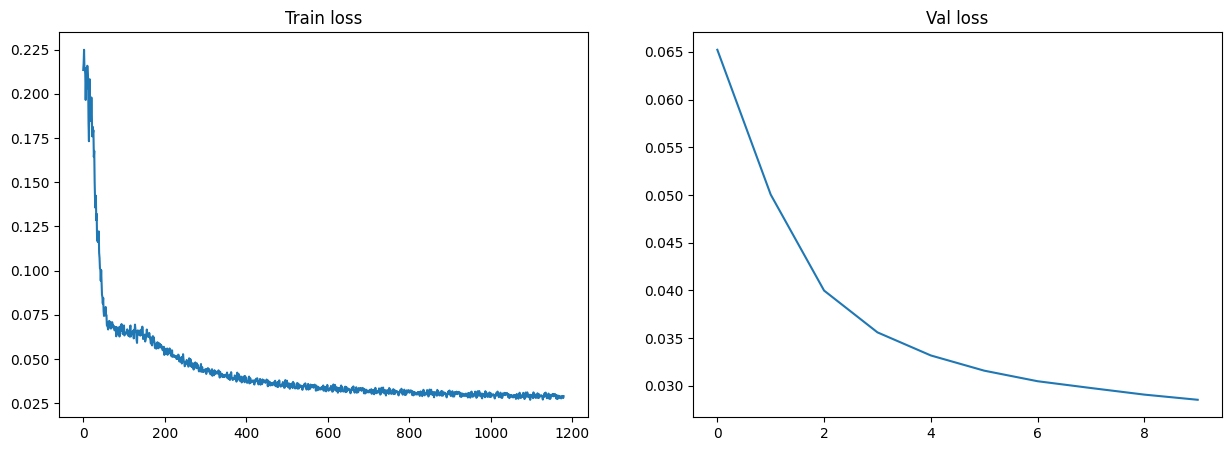

In [8]:
# Plot learning curves
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
axes[0].set_title('Train loss')
axes[0].plot(train_losses)
axes[1].set_title('Val loss')
axes[1].plot(val_losses)


## Model validation

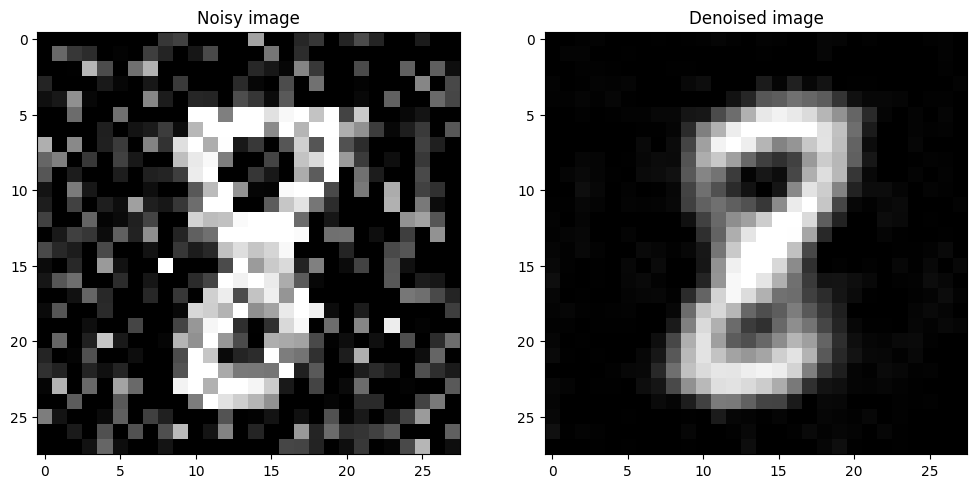

In [9]:
# Get sample
val_img, _ = sample(list(val_dataset), 1)[0]

# Add noise
noisy_val_img = add_noise(val_img)

# Predict denoised image
model.eval()
with torch.no_grad(): output = model(noisy_val_img.to(device)[None, ...])[0, ...]
denoised_val_img = output.clip(0, 1).cpu().numpy()

# Plot sample
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].set_title('Noisy image')
axes[0].imshow(noisy_val_img[0], cmap='gray')
axes[1].set_title('Denoised image')
axes[1].imshow(denoised_val_img[0], cmap='gray')